<a href="https://colab.research.google.com/github/ZGYAO93/skills-introduction-to-github/blob/main/examples/example_readme.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
# Uninstall the problematic packages
!pip uninstall -y numpy
!pip uninstall -y seaborn

# Install compatible versions
!pip install numpy==1.24.3
!pip install seaborn

Found existing installation: numpy 1.26.4
Uninstalling numpy-1.26.4:
  Successfully uninstalled numpy-1.26.4
Found existing installation: seaborn 0.13.2
Uninstalling seaborn-0.13.2:
  Successfully uninstalled seaborn-0.13.2
  Using cached numpy-1.24.3-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (5.6 kB)
Using cached numpy-1.24.3-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (17.3 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
missingno 0.5.2 requires seaborn, which is not installed.
pfhedge 0.23.0 requires numpy<2.0,>=1.26; python_version >= "3.9", but you have numpy 1.24.3 which is incompatible.
jaxlib 0.5.1 requires numpy>=1.25, but you have numpy 1.24.3 which is incompatible.
tensorflow 2.18.0 requires numpy<2.1.0,>=1.26.0, but you have numpy 1.24.3 which is incompatible.
albumentations 2.0.5 requires numpy>=1.24.4, 

  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)


In [1]:
!pip install pfhedge

  Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (18.3 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.24.3
    Uninstalling numpy-1.24.3:
      Successfully uninstalled numpy-1.24.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.


In [2]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import seaborn
import torch

In [3]:
seaborn.set_style("whitegrid")

FONTSIZE = 18
matplotlib.rcParams["figure.figsize"] = (10, 5)
matplotlib.rcParams["figure.dpi"] = 300
matplotlib.rcParams["figure.titlesize"] = FONTSIZE
matplotlib.rcParams["font.family"] = "sans-serif"
matplotlib.rcParams["legend.fontsize"] = FONTSIZE
matplotlib.rcParams["xtick.labelsize"] = FONTSIZE
matplotlib.rcParams["ytick.labelsize"] = FONTSIZE
matplotlib.rcParams["axes.labelsize"] = FONTSIZE
matplotlib.rcParams["axes.titlesize"] = FONTSIZE
matplotlib.rcParams["savefig.bbox"] = "tight"
matplotlib.rcParams["savefig.pad_inches"] = 0.1
matplotlib.rcParams["lines.linewidth"] = 2
matplotlib.rcParams["axes.linewidth"] = 1.6

In [4]:
torch.manual_seed(42)

if not torch.cuda.is_available():
    raise RuntimeWarning(
        "CUDA is not available. "
        "If you're using Google Colab, you can enable GPUs as: "
        "https://colab.research.google.com/notebooks/gpu.ipynb"
    )

DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Default device:", DEVICE)

Default device: cuda:0


In [5]:
# In each epoch, N_PATHS brownian motion time-series are generated.
N_PATHS = 50000
# How many times a model is updated in the experiment.
N_EPOCHS = 200

In [6]:
def to_numpy(tensor: torch.Tensor) -> np.array:
    return tensor.cpu().detach().numpy()

## How to Use

### Prepare Instruments

We consider a `BrownianStock`, which is a stock following the geometric Brownian motion, and a `EuropeanOption` which is contingent on it.

We assume that the stock has a transaction cost given by `cost`.

In [36]:
from pfhedge.instruments import BrownianStock, EuropeanOption, HestonStock

stock = HestonStock(cost=1e-1)
derivative = EuropeanOption(stock).to(DEVICE)

In [37]:
derivative

EuropeanOption(
  strike=1., maturity=0.0800
  (underlier): HestonStock(kappa=1., theta=0.0400, sigma=0.2000, rho=-0.7000, cost=0.1000, dt=0.0040, device='cuda:0')
)

### Create Your Hedger

We here use a multi-layer perceptron as our model.

In [38]:
from pfhedge.nn import Hedger
from pfhedge.nn import MultiLayerPerceptron

model = MultiLayerPerceptron()
hedger = Hedger(
    model, inputs=["log_moneyness", "expiry_time", "volatility", "prev_hedge"]
).to(DEVICE)

The `hedger` is also a [`Module`](https://pytorch.org/docs/stable/generated/torch.nn.Module.html#torch.nn.Module).

In [39]:
hedger

Hedger(
  inputs=['log_moneyness', 'expiry_time', 'volatility', 'prev_hedge']
  (model): MultiLayerPerceptron(
    (0): LazyLinear(in_features=0, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=32, bias=True)
    (5): ReLU()
    (6): Linear(in_features=32, out_features=32, bias=True)
    (7): ReLU()
    (8): Linear(in_features=32, out_features=1, bias=True)
    (9): Identity()
  )
  (criterion): EntropicRiskMeasure()
)

In [40]:
history = hedger.fit(derivative, n_epochs=N_EPOCHS, n_paths=N_PATHS, n_times=20)

Loss=0.0231: 100%|██████████| 200/200 [02:37<00:00,  1.27it/s]


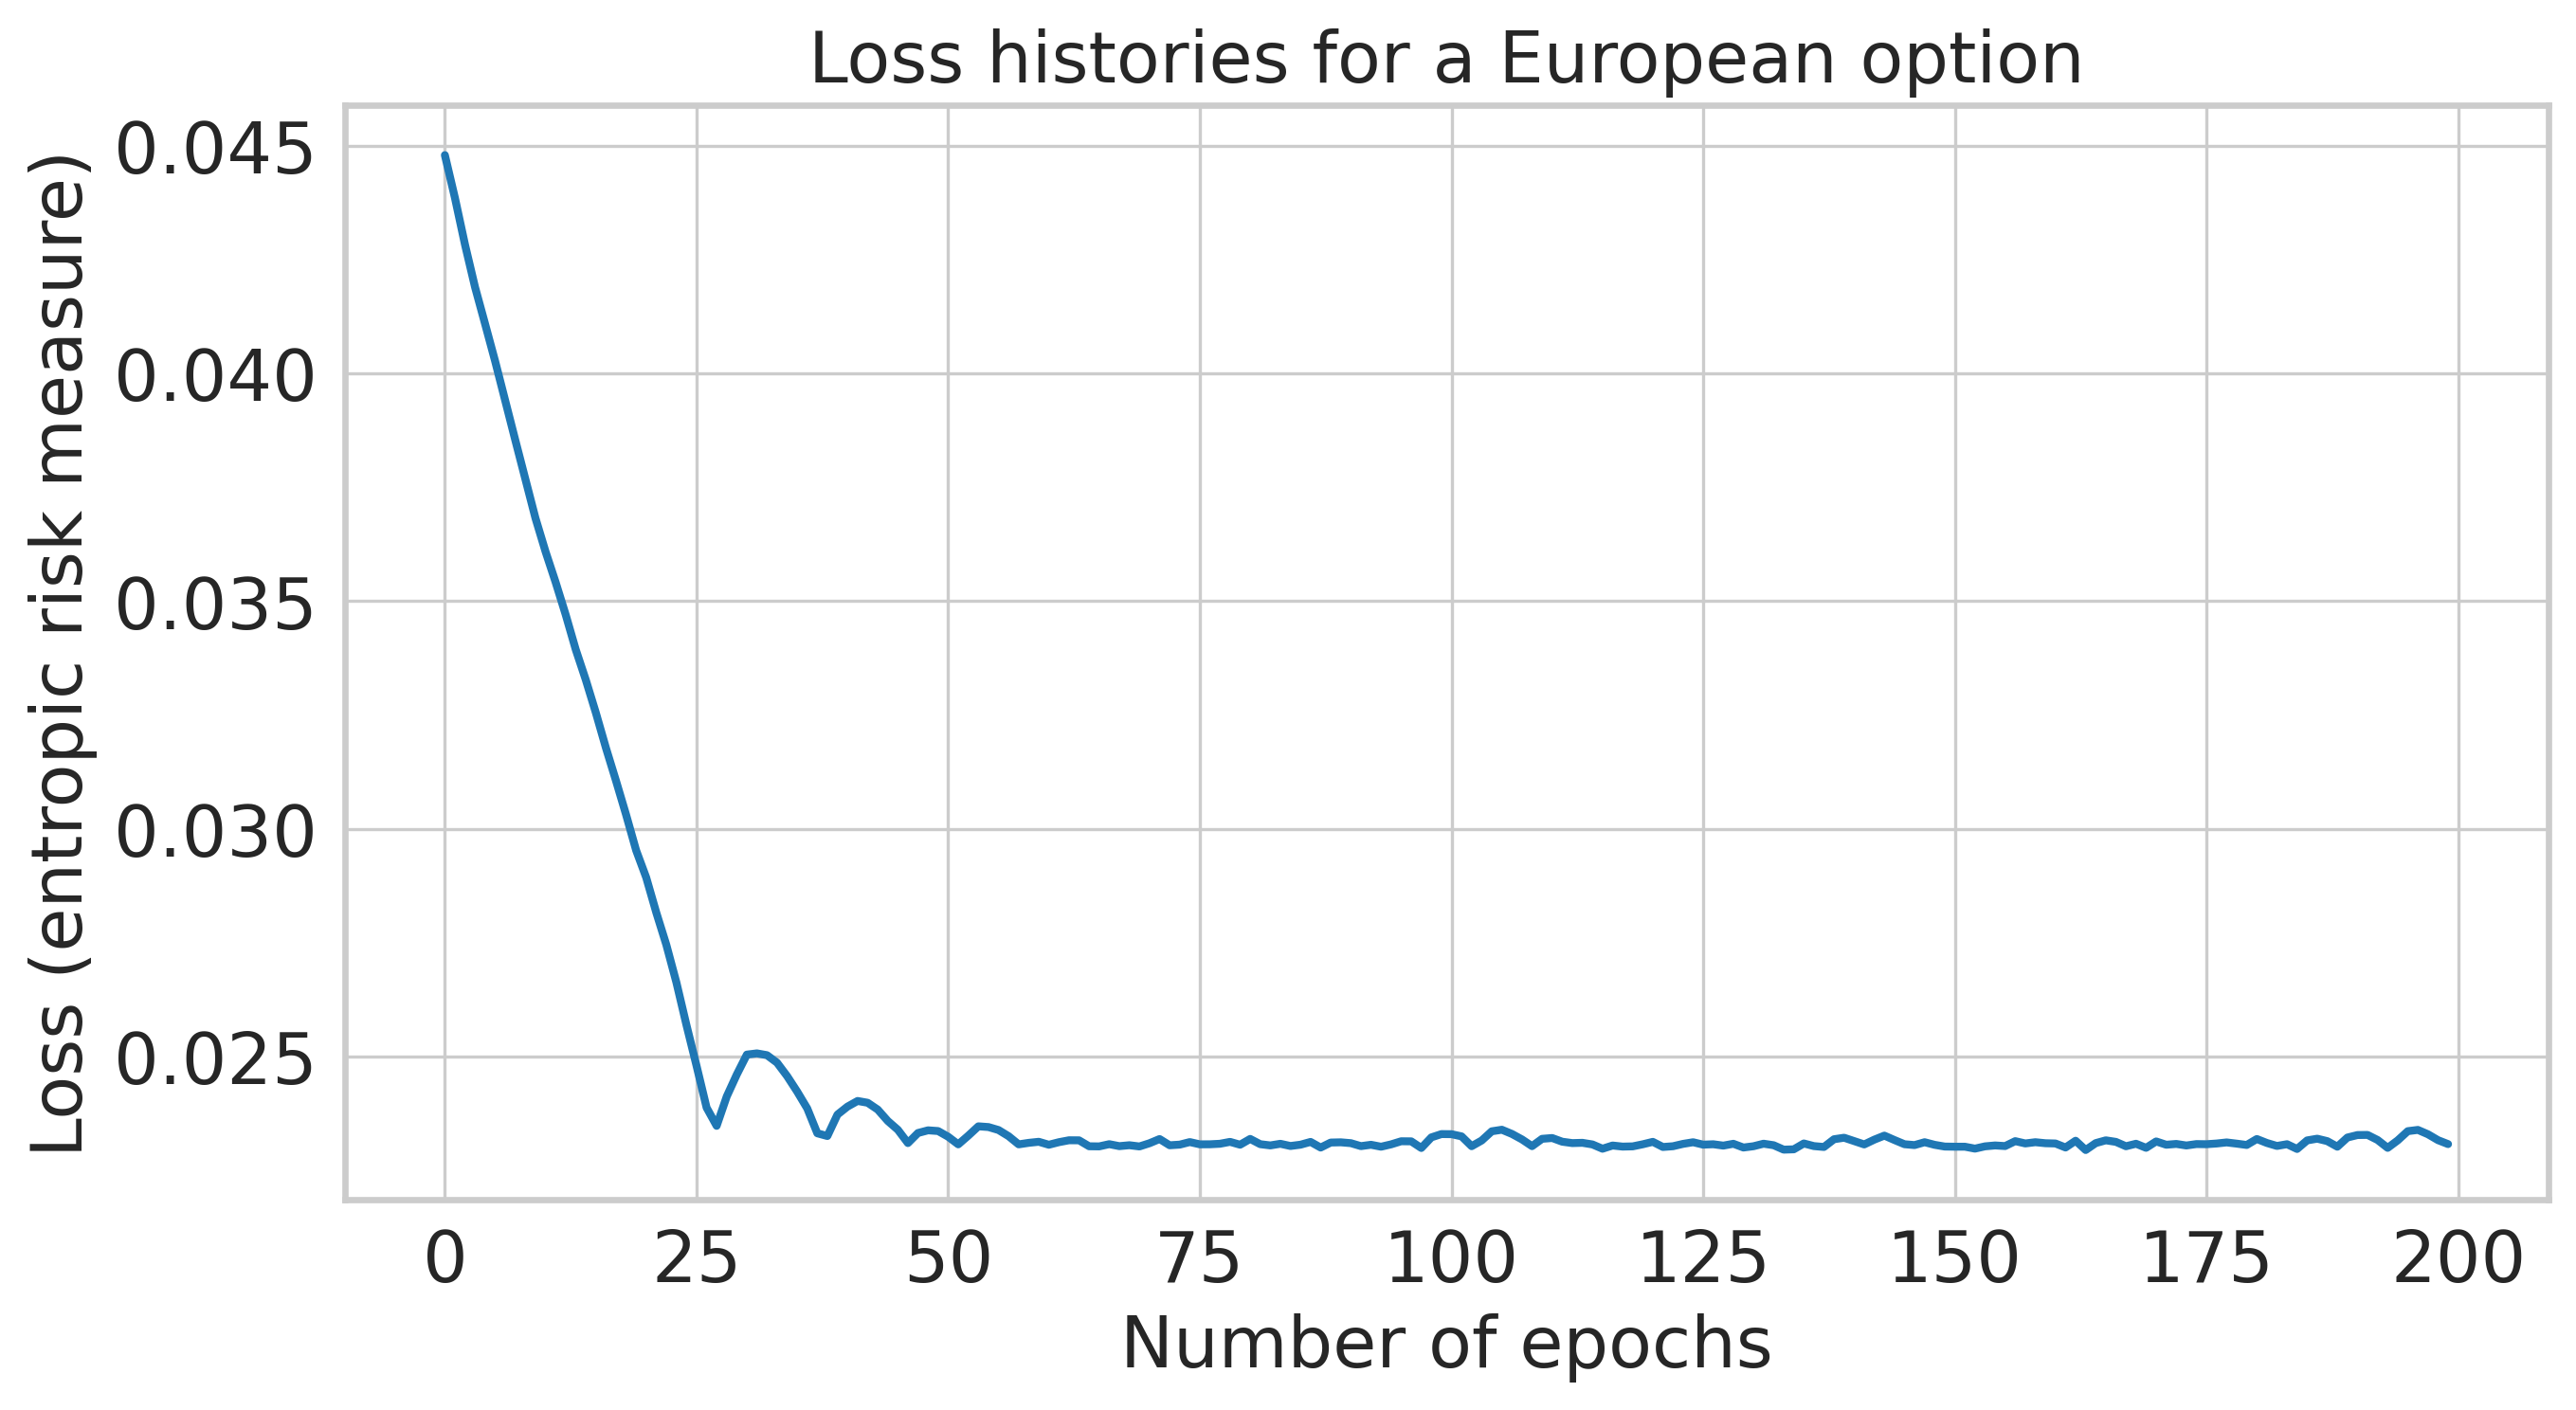

In [41]:
plt.plot(history)
plt.xlabel("Number of epochs")
plt.ylabel("Loss (entropic risk measure)")
plt.title("Loss histories for a European option")
plt.show()

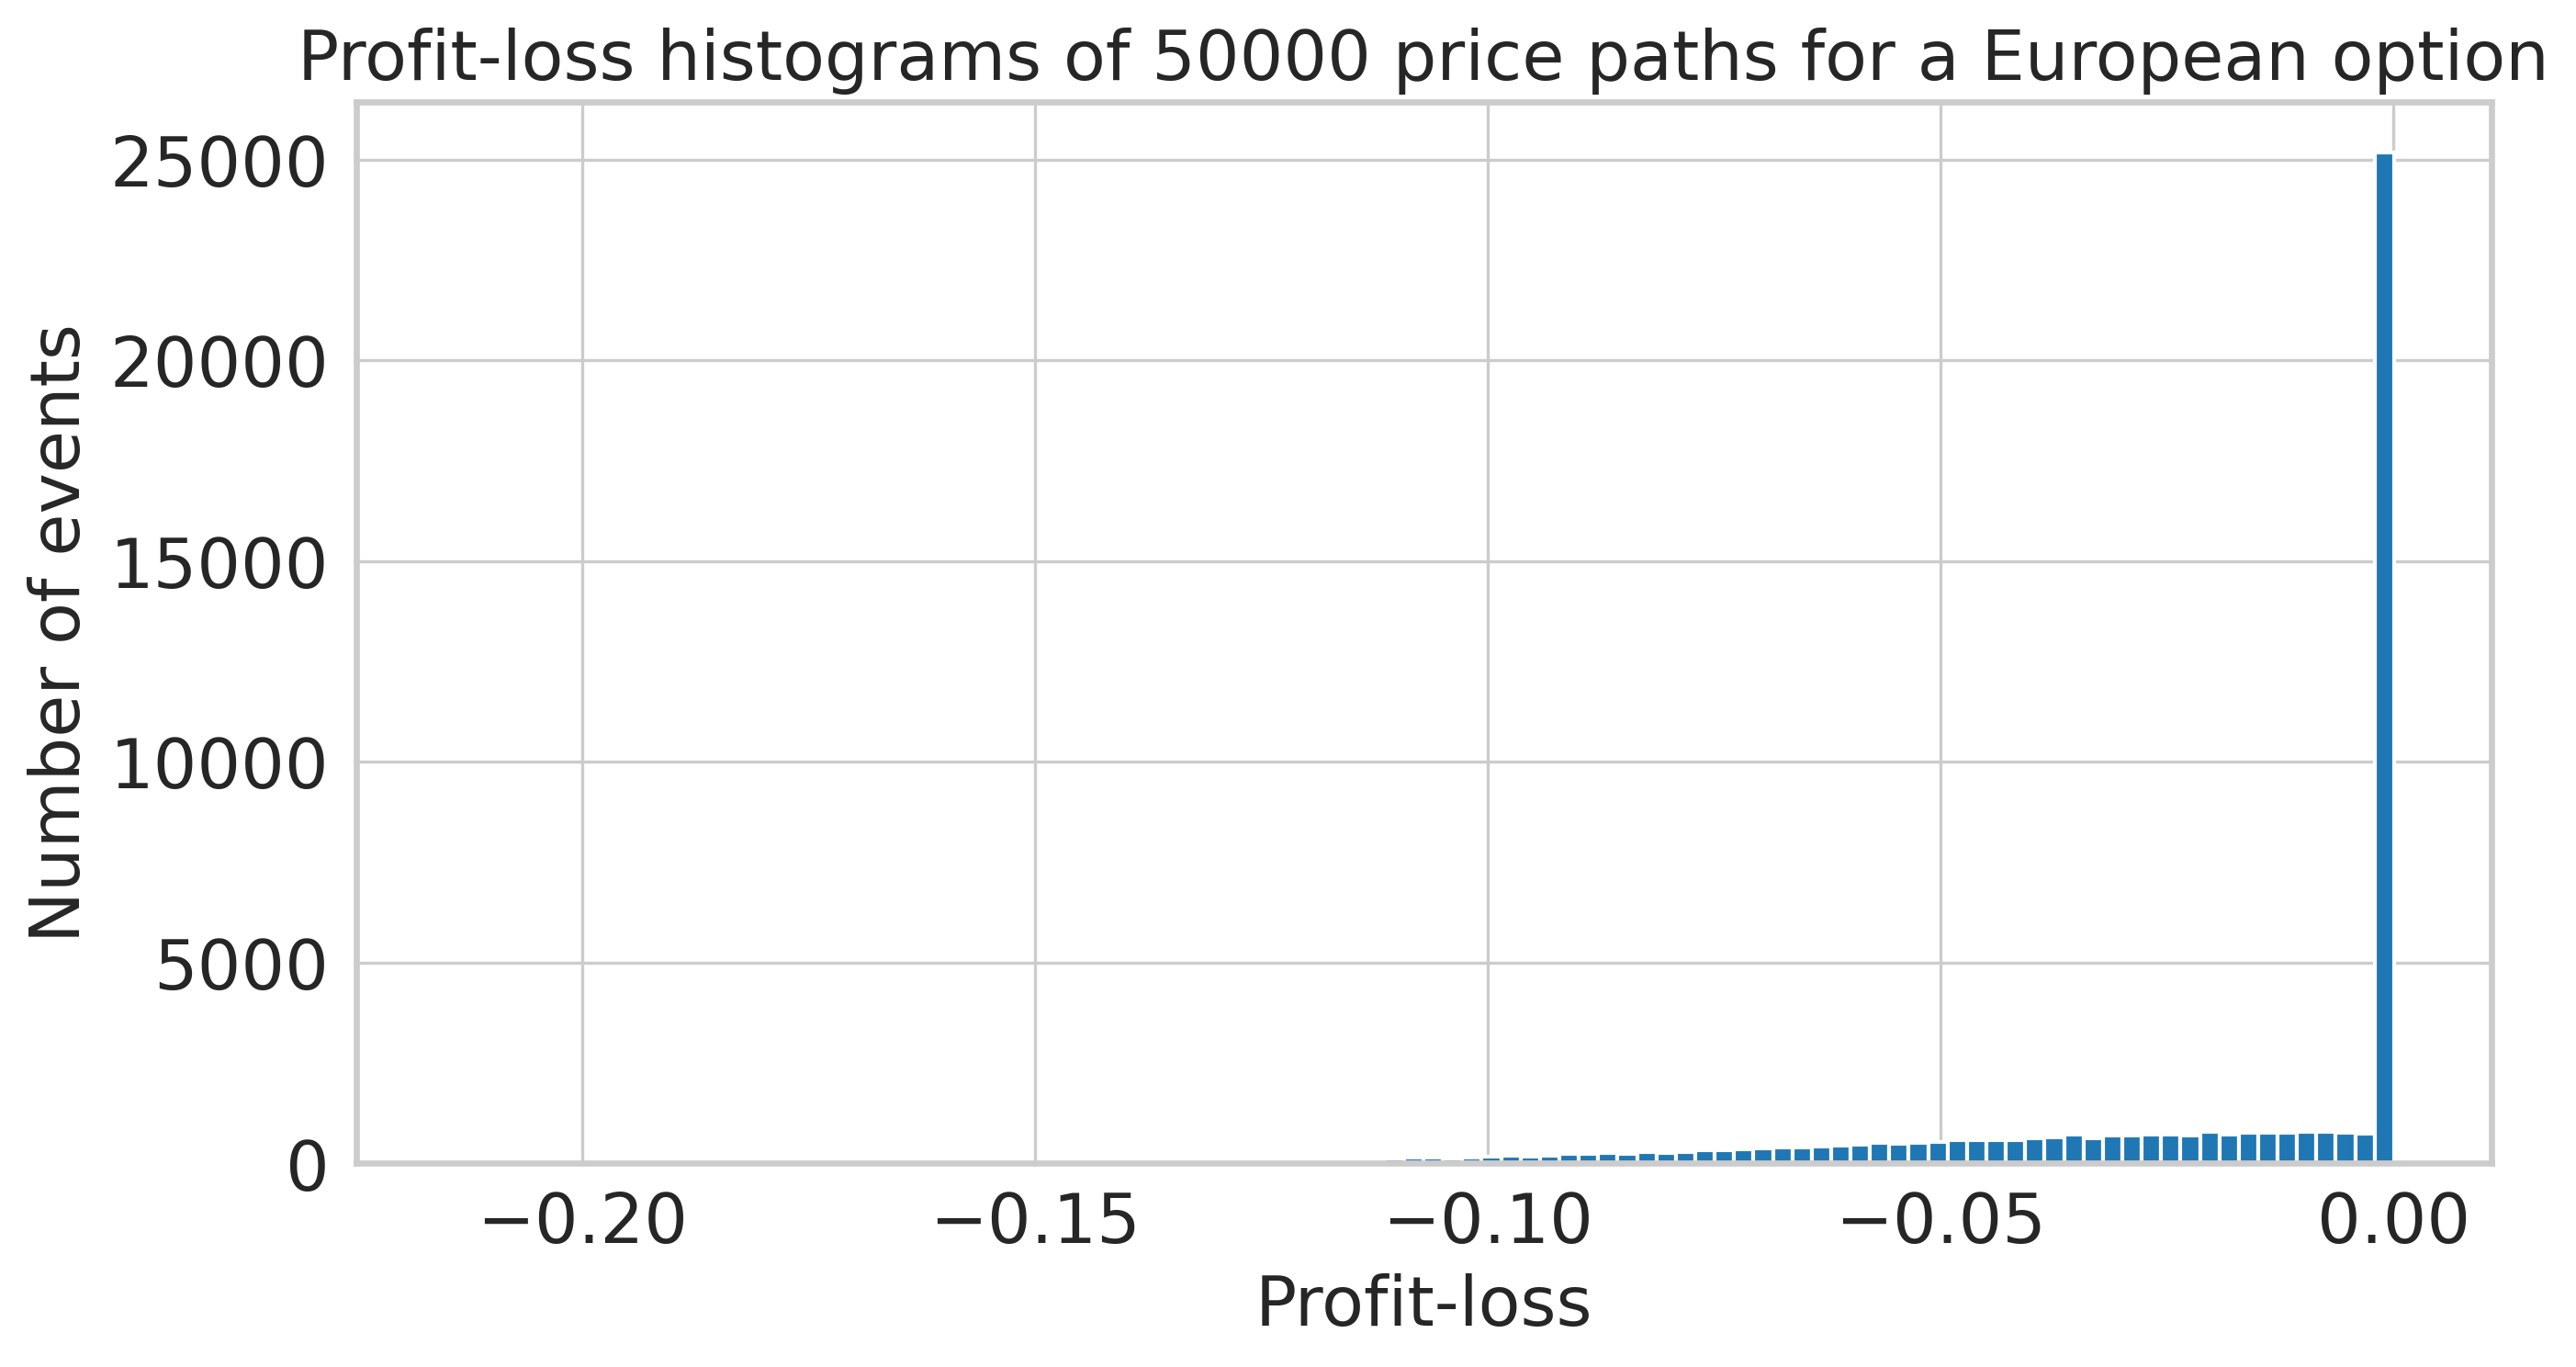

In [42]:
pnl = hedger.compute_pnl(derivative, n_paths=50000)

plt.figure()
plt.hist(to_numpy(pnl), bins=100)
plt.title("Profit-loss histograms of 50000 price paths for a European option")
plt.xlabel("Profit-loss")
plt.ylabel("Number of events")
plt.show()

In [43]:
price = hedger.price(derivative)
price

tensor(0.0231, device='cuda:0')

## More Examples

### Black-Scholes' Delta-Hedging Strategy

In [44]:
from pfhedge.nn import Hedger
from pfhedge.nn import BlackScholes

model = BlackScholes(derivative)
hedger = Hedger(model, inputs=model.inputs()).to(DEVICE)

In [30]:
hedger

Hedger(
  inputs=['log_moneyness', 'time_to_maturity', 'volatility']
  (model): BSEuropeanOption(strike=1.)
  (criterion): EntropicRiskMeasure()
)

In [31]:
price = hedger.price(derivative)
price

tensor(0.2136, device='cuda:0')

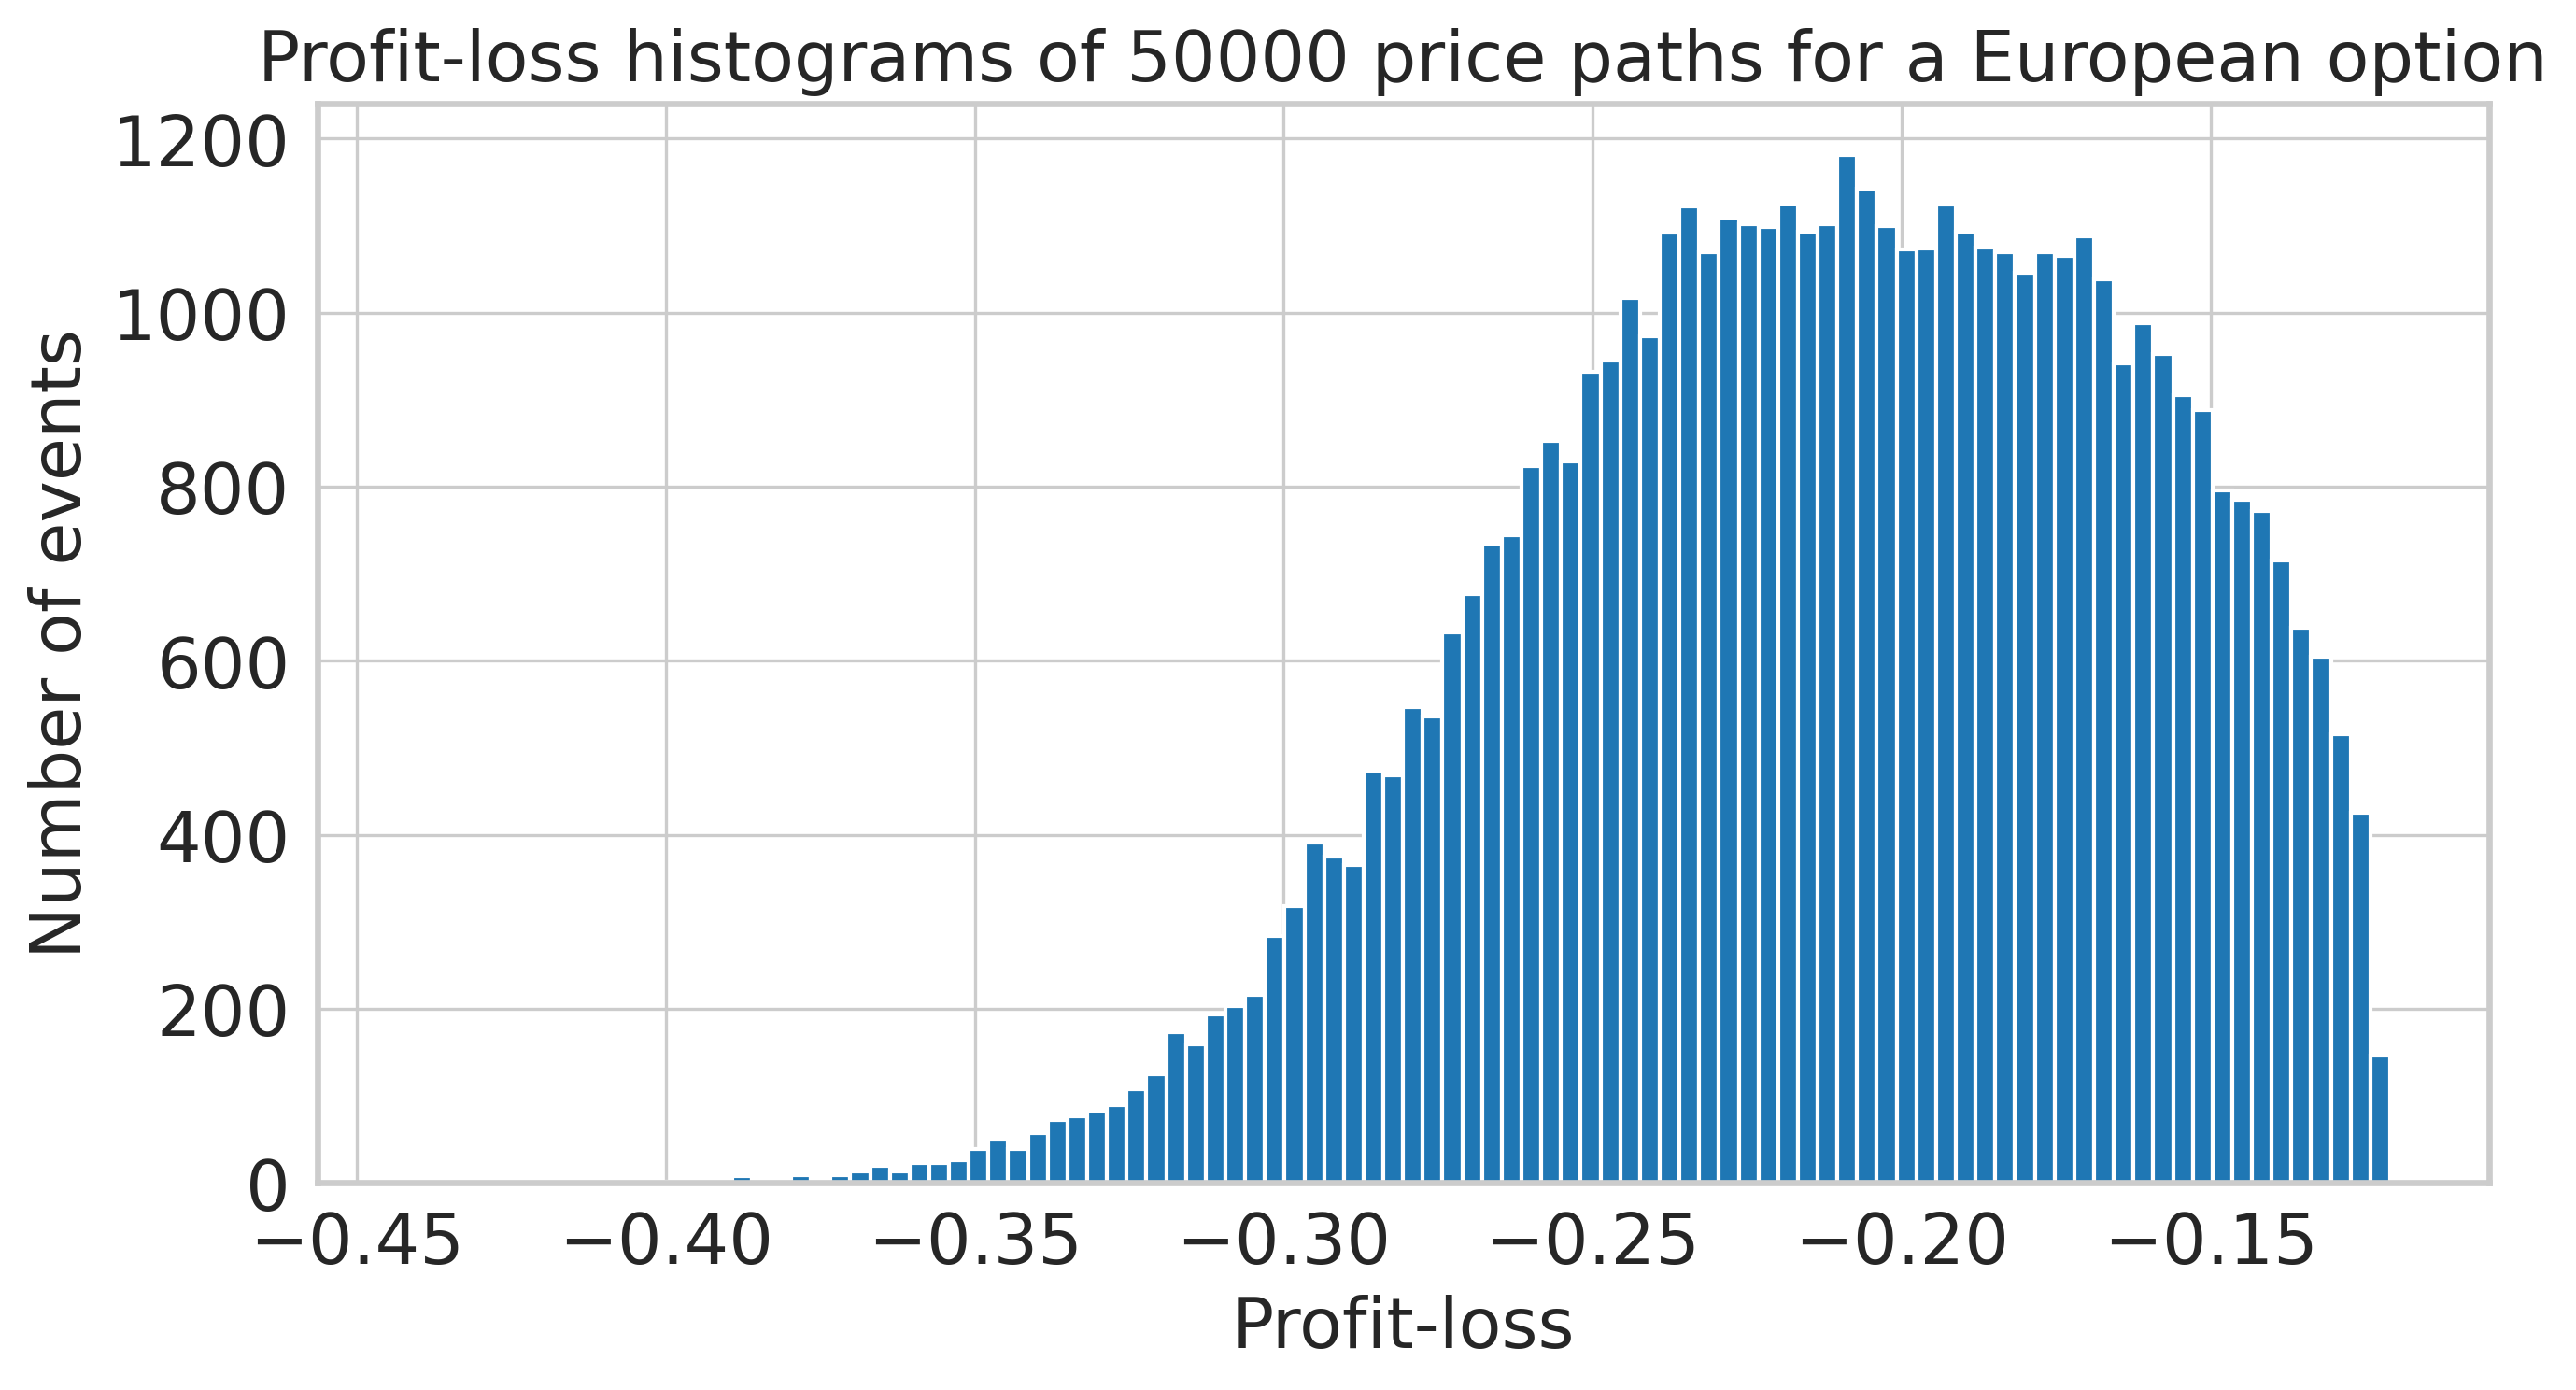

In [32]:
pnl = hedger.compute_pnl(derivative, n_paths=50000)

plt.figure()
plt.hist(to_numpy(pnl), bins=100)
plt.title("Profit-loss histograms of 50000 price paths for a European option")
plt.xlabel("Profit-loss")
plt.ylabel("Number of events")
plt.show()

### Whalley-Wilmott's Asymptotically Optimal Strategy for Small Costs

In [33]:
from pfhedge.nn import Hedger
from pfhedge.nn import WhalleyWilmott

model = WhalleyWilmott(derivative)
hedger = Hedger(model, inputs=model.inputs()).to(DEVICE)

In [34]:
price = hedger.price(derivative)
price

tensor(0.0524, device='cuda:0')

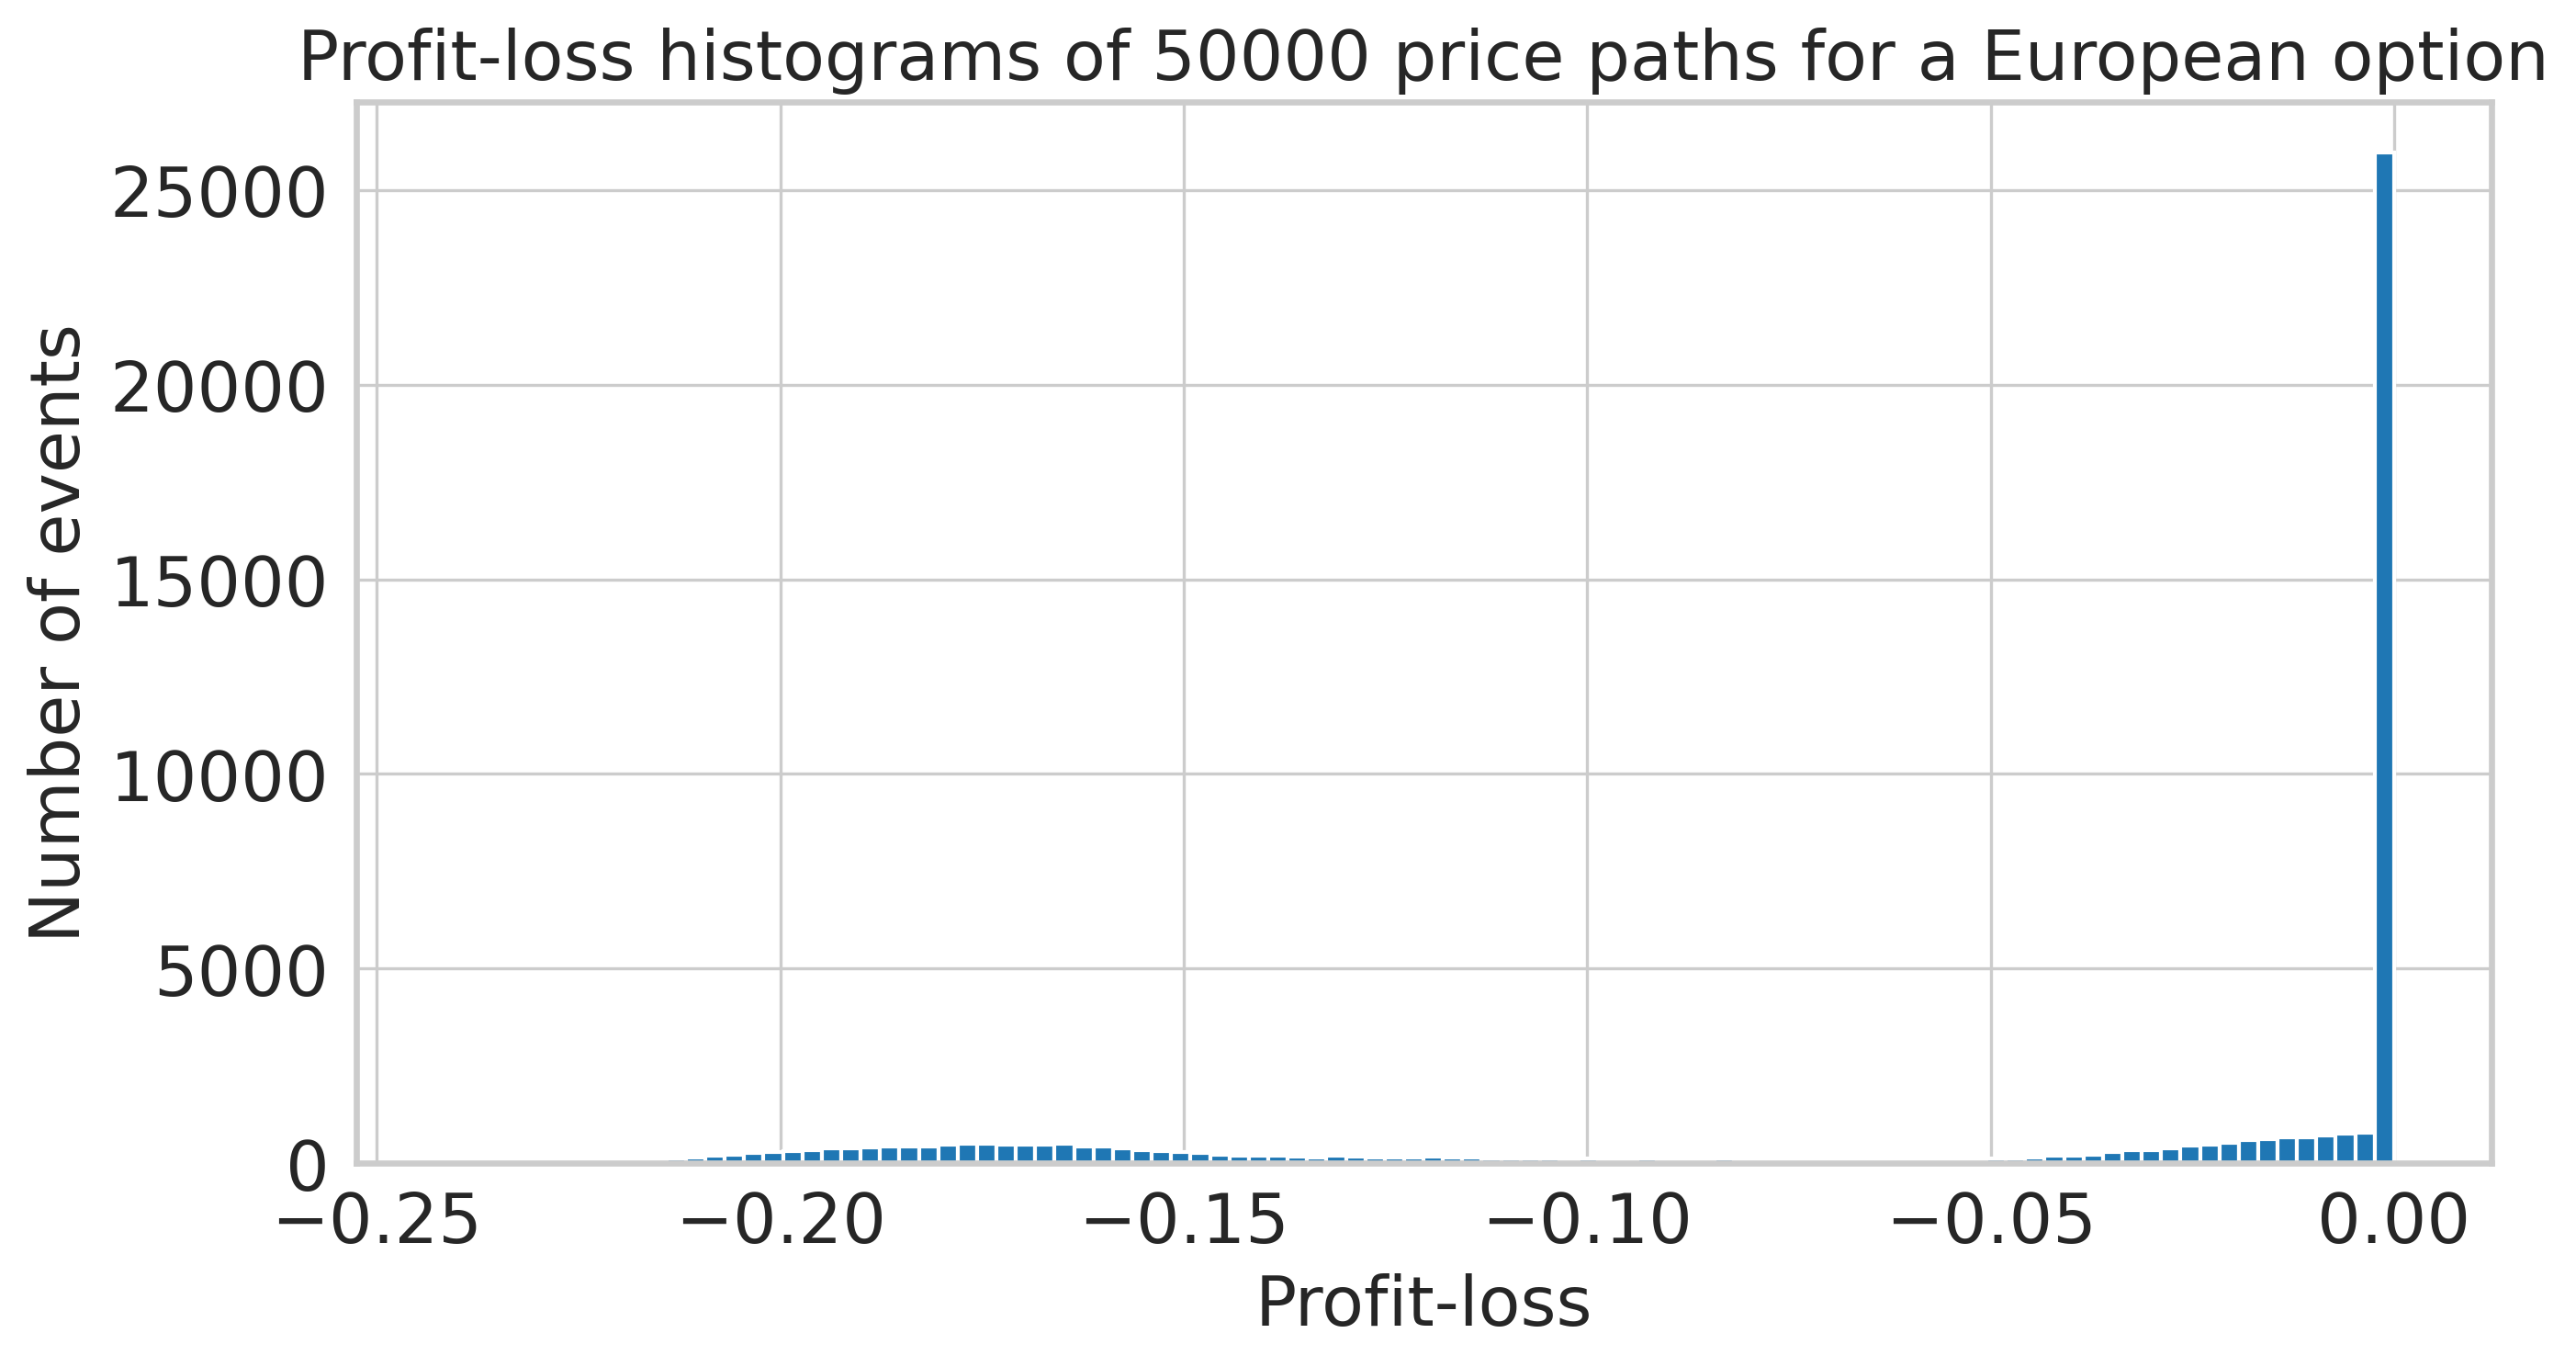

In [35]:
pnl = hedger.compute_pnl(derivative, n_paths=50000)

plt.figure()
plt.hist(to_numpy(pnl), bins=100)
plt.title("Profit-loss histograms of 50000 price paths for a European option")
plt.xlabel("Profit-loss")
plt.ylabel("Number of events")
plt.show()

### Your Own Module

In [ ]:
import torch.nn.functional as fn
from torch import Tensor
from torch.nn import Module

from pfhedge.nn import BlackScholes, Clamp, MultiLayerPerceptron


class NoTransactionBandNet(Module):
    def __init__(self, derivative):
        super().__init__()

        self.delta = BlackScholes(derivative)
        self.mlp = MultiLayerPerceptron(out_features=2)
        self.clamp = Clamp()

    def inputs(self):
        return self.delta.inputs() + ["prev_hedge"]

    def forward(self, input: Tensor) -> Tensor:
        prev_hedge = input[..., [-1]]

        delta = self.delta(input[..., :-1])
        width = self.mlp(input[..., :-1])

        min = delta - fn.leaky_relu(width[..., [0]])
        max = delta + fn.leaky_relu(width[..., [1]])

        return self.clamp(prev_hedge, min=min, max=max)

In [ ]:
model = NoTransactionBandNet(derivative)
hedger = Hedger(model, inputs=model.inputs()).to(DEVICE)

In [ ]:
history = hedger.fit(derivative, n_epochs=N_EPOCHS, n_paths=N_PATHS, n_times=20)

In [ ]:
plt.plot(history)
plt.xlabel("Number of epochs")
plt.ylabel("Loss (entropic risk measure)")
plt.title("Loss histories for a European option")
plt.show()

In [ ]:
pnl = hedger.compute_pnl(derivative, n_paths=50000)

plt.figure()
plt.hist(to_numpy(pnl), bins=100)
plt.title("Profit-loss histograms of 50000 price paths for a European option")
plt.xlabel("Profit-loss")
plt.ylabel("Number of events")
plt.show()

In [ ]:
price = hedger.price(derivative)
price

### Use Expected Shortfall as a Loss function

In [ ]:
from pfhedge.nn import ExpectedShortfall

In [ ]:
# Expected shortfall with the quantile level of 10%
expected_shortfall = ExpectedShortfall(0.1)

model = NoTransactionBandNet(derivative)
hedger = Hedger(model, inputs=model.inputs(), criterion=expected_shortfall).to(DEVICE)

In [ ]:
history = hedger.fit(derivative, n_epochs=N_EPOCHS, n_paths=N_PATHS, n_times=20)

In [ ]:
plt.plot(history)
plt.xlabel("Number of epochs")
plt.ylabel("Loss (entropic risk measure)")
plt.title("Loss histories for a European option")
plt.show()

In [ ]:
pnl = hedger.compute_pnl(derivative, n_paths=50000)

plt.figure()
plt.hist(to_numpy(pnl), bins=100)
plt.title("Profit-loss histograms of 50000 price paths for a European option")
plt.xlabel("Profit-loss")
plt.ylabel("Number of events")
plt.show()

In [ ]:
price = hedger.price(derivative)
price